In [15]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os 
from mne.datasets.limo import load_data
from mne.stats import linear_regression
from mne.viz import plot_events, plot_compare_evokeds
from mne import combine_evoked
from mne.minimum_norm import apply_inverse, make_inverse_operator, get_point_spread, make_inverse_resolution_matrix

import warnings
warnings.filterwarnings('ignore')

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
limo_epochs = []
for subj in range(1,19):
    limo_epochs.append(load_data(subject=subj))

Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1055 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1052 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1072 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1050 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1118 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1108 matching ev

## ERPs Visualization

In [4]:
sbj2use = 0 #subject 0

Let’s plot the ERPs evoked by Face A and Face B, to see how similar they are.

No projector specified for this dataset. Please consider the method self.add_proj.


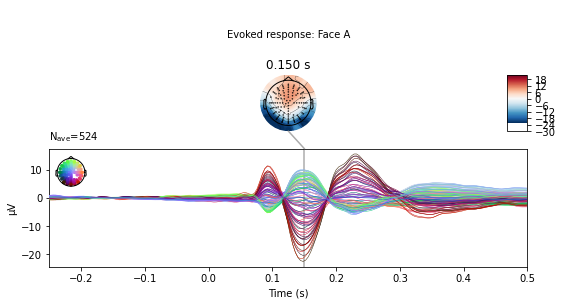

No projector specified for this dataset. Please consider the method self.add_proj.


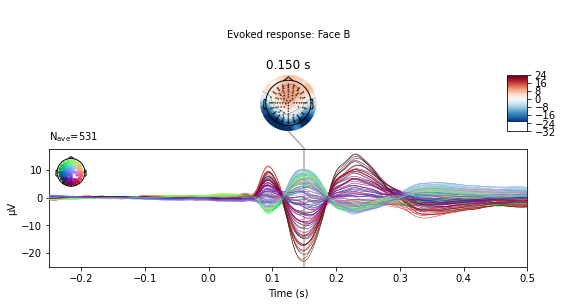

In [6]:
# only show -250 to 500 ms
ts_args = dict(xlim=(-0.25, 0.5))

# plot evoked response for face A
limo_epochs[sbj2use]['Face/A'].average().plot_joint(times=[0.15],
                                           title='Evoked response: Face A',
                                           ts_args=ts_args);
# and face B
limo_epochs[sbj2use]['Face/B'].average().plot_joint(times=[0.15],
                                           title='Evoked response: Face B',
                                           ts_args=ts_args);

We can also compute the difference wave contrasting Face A and Face B. Although, looking at the evoked responses above, we shouldn’t expect great differences among these face-stimuli.

No projector specified for this dataset. Please consider the method self.add_proj.


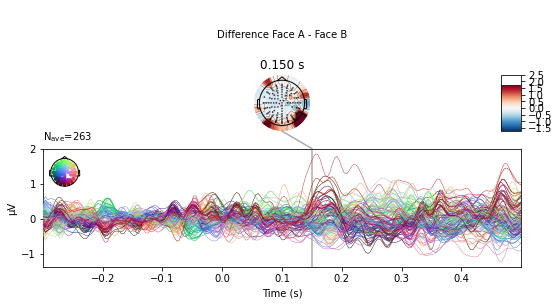

In [7]:
# Face A minus Face B
difference_wave = combine_evoked([limo_epochs[sbj2use]['Face/A'].average(),
                                  limo_epochs[sbj2use]['Face/B'].average()],
                                 weights=[1, -1])

# plot difference wave
difference_wave.plot_joint(times=[0.15], title='Difference Face A - Face B');

As expected, no clear pattern appears when contrasting Face A and Face B. However, we could narrow our search a little bit more. 

Indeed we can also explore the differences based on stimuli's phase-coherence.

Since phase-coherence determined whether a face stimulus could be easily identified, one could expect that faces with high phase-coherence should evoke stronger activation patterns along occipital electrodes.

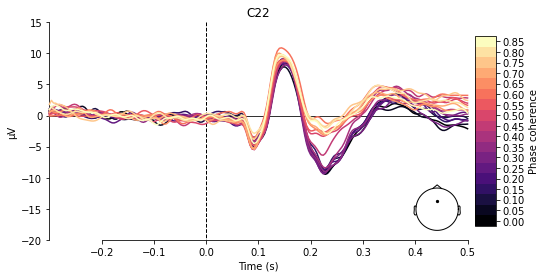

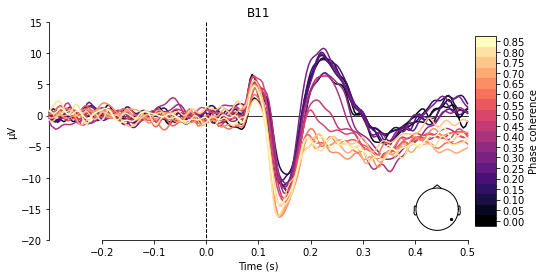

In [16]:
phase_coh = limo_epochs[sbj2use].metadata['phase-coherence']
# get levels of phase coherence
levels = sorted(phase_coh.unique())

# create labels for levels of phase coherence (i.e., 0 - 85%)
labels = ["{0:.2f}".format(i) for i in np.arange(0., 0.90, 0.05)]

# create dict of evokeds for each level of phase-coherence
evokeds = {label: limo_epochs[sbj2use][phase_coh == level].average()
           for level, label in zip(levels, labels)}

# pick channel to plot
electrodes = ['C22', 'B11']
# create figures
for electrode in electrodes:
    fig, ax = plt.subplots(figsize=(8, 4))
    plot_compare_evokeds(evokeds,
                         axes=ax,
                         ylim=dict(eeg=(-20, 15)),
                         picks=electrode,
                         cmap=("Phase coherence", "magma"))

As shown above, there are some considerable differences between the activation patterns evoked by stimuli with low vs. high phase-coherence at the chosen electrodes.

## Let's collected the evoked responses

In [17]:
phase_coh = limo_epochs[sbj2use].metadata['phase-coherence']
# get levels of phase coherence
levels = sorted(phase_coh.unique())
# create labels for levels of phase coherence (i.e., 0 - 85%)
labels = ["{0:.2f}".format(i) for i in np.arange(0., 0.90, 0.05)]

# create dict of evokeds for each level of phase-coherence
epocheds = {label: limo_epochs[sbj2use][phase_coh == level]
           for level, label in zip(levels, labels)}

In [18]:
epocheds.keys()

dict_keys(['0.00', '0.05', '0.10', '0.15', '0.20', '0.25', '0.30', '0.35', '0.40', '0.45', '0.50', '0.55', '0.60', '0.65', '0.70', '0.75', '0.80', '0.85'])

Let's visualize ERPs for phase-coherence of 0.85

First we need to create a montage for our eeg data

In [19]:
thr2use = '0.85'

epoched = epocheds[thr2use]
ch_names = epoched.info.ch_names[:128] #only taking the eeg electrodes
ch_names_lower = np.array([x.lower() if isinstance(x, str) else x for x in ch_names])

#using a standard montage
standard_1020_montage = mne.channels.make_standard_montage('biosemi128')
standard_1020_ch_names_lower = np.array([x.lower() if isinstance(x, str) else x for x in standard_1020_montage.ch_names]).tolist()


#reordering the electrodes 
pos_ordered = dict()

for x in range(0, len(ch_names)):
    index=standard_1020_ch_names_lower.index(ch_names_lower[x])
    ch_names[x]=standard_1020_montage.ch_names[index]
    pos_ordered[ch_names[x]] = standard_1020_montage.dig[index]['r']

    
nasion = standard_1020_montage.dig[1]['r']
lpa = standard_1020_montage.dig[0]['r']
rpa = standard_1020_montage.dig[2]['r']

montage = mne.channels.make_dig_montage(pos_ordered, nasion, lpa, rpa, coord_frame='mri')

Then we are going to create and mne evoked object 

In [21]:
sfreq = 250
tmax = epoched.times[-1]

info = mne.create_info(ch_names=ch_names,sfreq=sfreq,ch_types='eeg')

epoched =mne.EpochsArray(epoched._data[:,:128,:],info,tmin=epoched.times[0]) 
epoched.set_montage(montage)
evoked = epoched.average()
evoked.set_eeg_reference('average', projection=True, verbose=False);
evoked.apply_baseline()

Not setting metadata
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Applying baseline correction (mode: mean)


<Evoked | '1' (average, N=59), -0.3 – 0.5 sec, baseline -0.3 – 0 sec, 128 ch, ~378 kB>

Finally we are ready to plot ERPs

Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


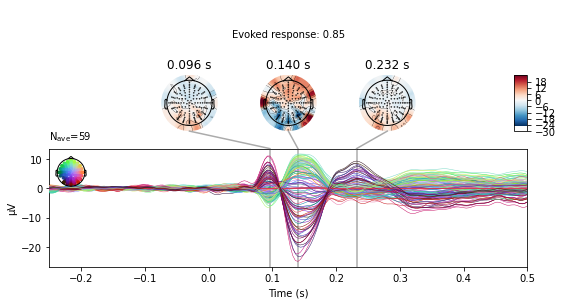

In [23]:
# only show -250 to 500 ms
ts_args = dict(xlim=(-0.25, 0.5))

ch, peak_locs1 = evoked.get_peak(ch_type='eeg', tmin=0.05, tmax=0.1)
ch, peak_locs2 = evoked.get_peak(ch_type='eeg', tmin=0.1, tmax=0.2)
ch, peak_locs3 = evoked.get_peak(ch_type='eeg', tmin=0.2, tmax=0.25)

times = [peak_locs1, peak_locs2, peak_locs3]

evoked.plot_joint(times=times, title='Evoked response: ' + thr2use , ts_args=ts_args);
